In [4]:
import zipfile
import os
# Extract ECG data
zip_path = 'ecg_data.zip'
extract_path = '.'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load dataset
data_path = os.path.join(extract_path, 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

# Print dataset info
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Extracting features and labels
x = data.iloc[:, 0:-1].values  # Selecting all columns except last
y = data.iloc[:, -1].values  # Selecting last column as labels



The number of samples: 827
The number of columns: 9001


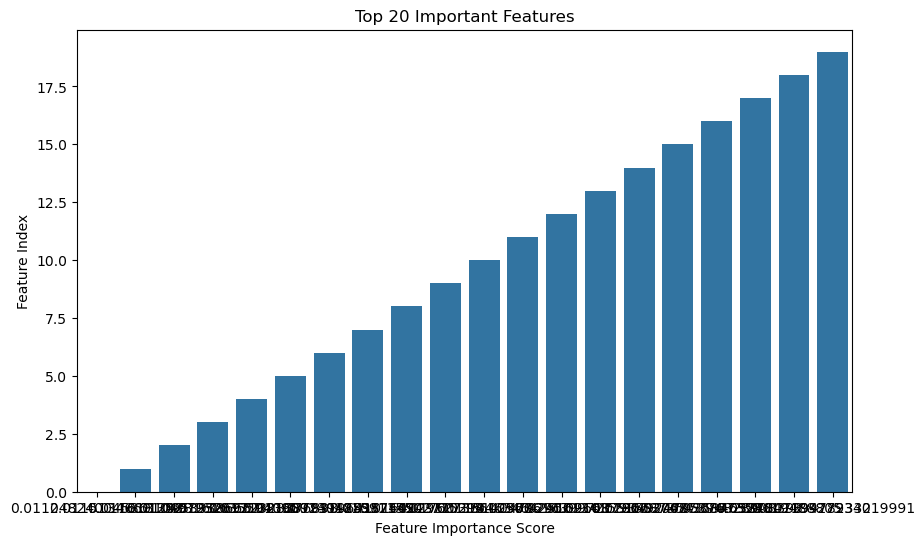

Train Accuracy: 1.0
Train AUC: 1.0
Train F1: 1.0
Train Precision: 1.0
Train Recall: 1.0
Test Accuracy: 0.9560439560439561
Test AUC: 0.990446543580936
Test F1: 0.9568345323741008
Test Precision: 0.9366197183098591
Test Recall: 0.9779411764705882


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier

# 1. Data Preprocessing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(x)

# 2. Feature Selection
k_best = 500  # Keep top 500 features
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X_imputed, y)

# 3. SMOTE for class balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# 4. PCA for dimensionality reduction
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_resampled)

# 5. Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_pca, y_resampled):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

# 6. Random Forest with regularization and Feature Importance
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)

# Plot feature importance
feature_importance = rf_clf.feature_importances_
top_features = np.argsort(feature_importance)[-20:]  # Top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(y=np.arange(len(top_features)), x=feature_importance[top_features])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Index")
plt.title("Top 20 Important Features")
plt.show()

# 7. XGBoost Classifier with regularization
xgb_clf = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, scale_pos_weight=1, random_state=42, reg_alpha=0.1, reg_lambda=0.1)
xgb_clf.fit(X_train, y_train)

# 8. Hyperparameter tuning with GridSearchCV for RandomForest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf_clf = grid_search_rf.best_estimator_

# 9. Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf_clf),
    ('xgb', xgb_clf)
], voting='soft')  # 'soft' means weighted average of predictions

voting_clf.fit(X_train, y_train)
y_pred_train = voting_clf.predict(X_train)
y_pred_test = voting_clf.predict(X_test)

# Compute scores for training set
y_score_train = voting_clf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_score_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
F1_train = f1_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)

# Compute scores for test set
y_score_test = voting_clf.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_score_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
F1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)

# Print evaluation metrics
print(f'Train Accuracy: {accuracy_train}')
print(f'Train AUC: {auc_train}')
print(f'Train F1: {F1_train}')
print(f'Train Precision: {precision_train}')
print(f'Train Recall: {recall_train}')
print(f'Test Accuracy: {accuracy_test}')
print(f'Test AUC: {auc_test}')
print(f'Test F1: {F1_test}')
print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')


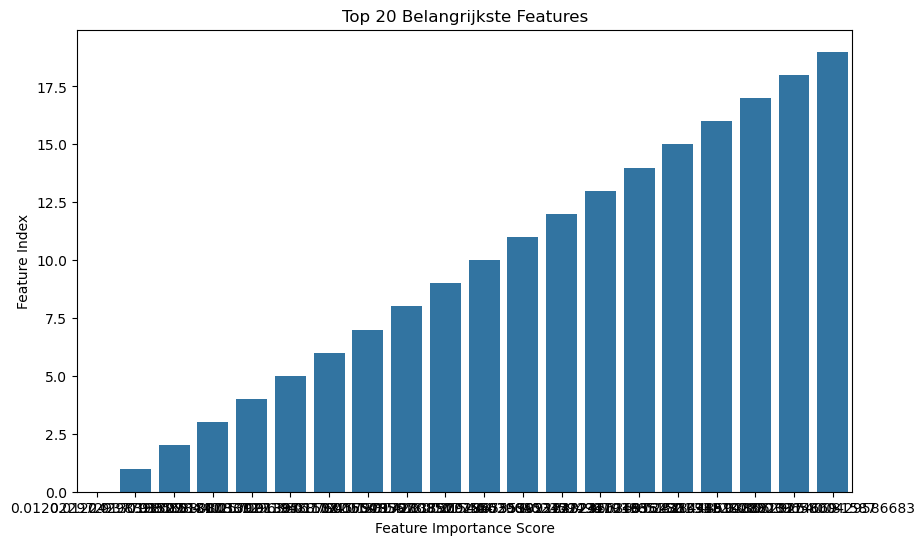

Final Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       137
           1       0.93      0.97      0.95       136

    accuracy                           0.95       273
   macro avg       0.95      0.95      0.95       273
weighted avg       0.95      0.95      0.95       273

Final Confusion Matrix:
 [[127  10]
 [  4 132]]


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 1. Data Preprocessing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(x)

# 2. Feature Selection
k_best = 500  # Houd de beste 500 features
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X_imputed, y)

# 3. SMOTE voor class balancing (Synthetic minority Over-sampling Technique)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# 4. PCA voor dimensiereductie
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_resampled)

# 5. Data splitsen
for train_idx, test_idx in sss.split(X_pca, y_resampled):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

# 6. Random Forest met Feature Importance
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)

# Plot feature importance
feature_importance = rf_clf.feature_importances_
top_features = np.argsort(feature_importance)[-20:]  # Top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(y=np.arange(len(top_features)), x=feature_importance[top_features])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Index")
plt.title("Top 20 Belangrijkste Features")
plt.show()

# 7. XGBoost Classifier
xgb_clf = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.05, scale_pos_weight=1, random_state=42)
xgb_clf.fit(X_train, y_train)

# 8. Hyperparameter Tuning met RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=sss,
                                   scoring='accuracy',
                                   random_state=42,
                                   n_jobs=-1)
random_search.fit(X_train, y_train)
best_rf_clf = random_search.best_estimator_

# 9. Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf_clf),
    ('xgb', xgb_clf)
], voting='soft')  # 'soft' betekent gewogen gemiddelde van voorspellingen

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# 10. Evaluatie
print("Final Classification Report:\n", classification_report(y_test, y_pred))
print("Final Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


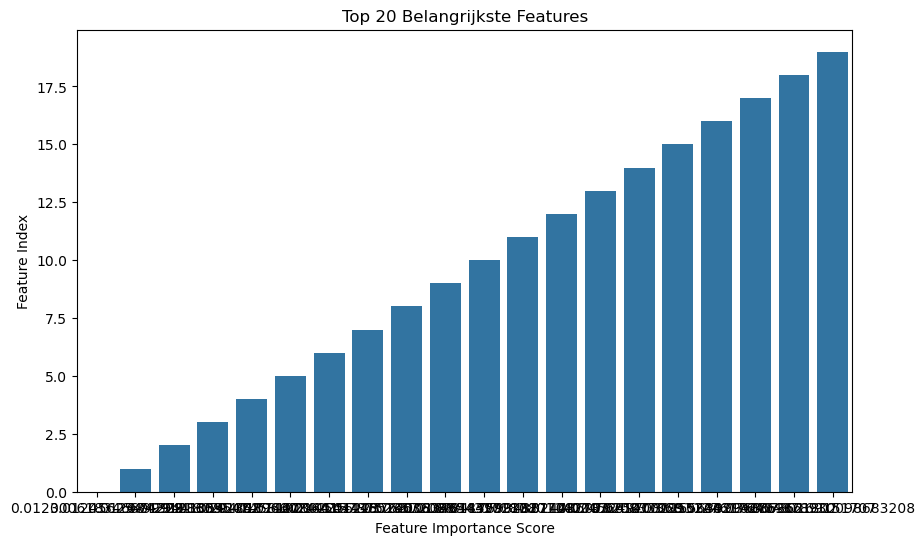

Train Accuracy: 1.0
Train AUC: 1.0
Train F1: 1.0
Train Precision: 1.0
Train Recall: 1.0
Test Accuracy: 0.9377289377289377
Test AUC: 0.9854014598540145
Test F1: 0.9386281588447654
Test Precision: 0.9219858156028369
Test Recall: 0.9558823529411765


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier

# 1. Data Preprocessing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(x)

# 2. Feature Selection
k_best = 500  # Houd de beste 500 features
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X_imputed, y)

# 3. SMOTE voor class balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# 4. PCA voor dimensiereductie
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_resampled)

# 5. Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_pca, y_resampled):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

# 6. Random Forest met Feature Importance
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)

# Plot feature importance
feature_importance = rf_clf.feature_importances_
top_features = np.argsort(feature_importance)[-20:]  # Top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(y=np.arange(len(top_features)), x=feature_importance[top_features])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Index")
plt.title("Top 20 Belangrijkste Features")
plt.show()

# 7. XGBoost Classifier
xgb_clf = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.05, scale_pos_weight=1, random_state=42)
xgb_clf.fit(X_train, y_train)

# 8. Hyperparameter Tuning met RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=sss,
                                   scoring='accuracy',
                                   random_state=42,
                                   n_jobs=-1)
random_search.fit(X_train, y_train)
best_rf_clf = random_search.best_estimator_

# 9. Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf_clf),
    ('xgb', xgb_clf)
], voting='soft')  # 'soft' betekent gewogen gemiddelde van voorspellingen

voting_clf.fit(X_train, y_train)
y_pred_train = voting_clf.predict(X_train)
y_pred_test = voting_clf.predict(X_test)

# Compute scores for training set
y_score_train = voting_clf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_score_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
F1_train = f1_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)

# Compute scores for test set
y_score_test = voting_clf.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_score_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
F1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)

# Print evaluation metrics
print(f'Train Accuracy: {accuracy_train}')
print(f'Train AUC: {auc_train}')
print(f'Train F1: {F1_train}')
print(f'Train Precision: {precision_train}')
print(f'Train Recall: {recall_train}')
print(f'Test Accuracy: {accuracy_test}')
print(f'Test AUC: {auc_test}')
print(f'Test F1: {F1_test}')
print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')
